In [18]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras import backend

import time
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD

from scipy.optimize import fmin_l_bfgs_b
tf.compat.v1.disable_eager_execution()



In [19]:
def preprocess_image(image_path):

    image=Image.open(image_path)
    image=image.resize((512,512))

    img_array=np.asarray(image,dtype='float32')
    img_array=np.expand_dims(img_array,axis=0)


    img_array[:, :, :,0]-=103.939
    img_array[:, :, :,1]-=116.779
    img_array[:, :, :,2]-=123.68

    img_array=img_array[:, :, :,::-1]
    return img_array


In [20]:
def deprocess_image(x):
    x = x.reshape((512, 512, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [21]:
content_array=preprocess_image('GoldenGateBridge-001.jpg')
style_array=preprocess_image('davinci.jpeg')

In [22]:
content_array.shape

(1, 512, 512, 3)

In [23]:
alpha= 0.025
beta=5.0
gamma=1.00

In [24]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
final_image = backend.placeholder((1, 512, 512, 3))

In [25]:
input_tensor=backend.concatenate([content_image,style_image,final_image], axis=0)
loss=backend.variable(0.)
model= VGG16(input_tensor=input_tensor,weights='imagenet',include_top=False)
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_2': <tf.Tensor 'concat_1:0' shape=(3, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32

In [26]:
def content_loss(content,final):
    return backend.sum(backend.square(final-content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + alpha * content_loss(content_image_features,
                                      combination_features)

In [27]:
def gram_matrix(T):
    features=backend.batch_flatten(backend.permute_dimensions(T, (2,0,1)))
    gram = backend.dot(features,backend.transpose(features))
    return gram

In [28]:
def style_loss(style,final):
    sty=  gram_matrix(style)
    fin= gram_matrix(final)
    return backend.sum(backend.square(sty-fin))/ (4 * (3**2) * (262144**2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss = loss +(beta / len(feature_layers)) * sl

In [29]:
def total_var_loss(T):
    a= backend.square(T[:,:511,:511,:]-T[:,1:,:511,:])
    b= backend.square(T[:,:511,:511,:]-T[:,:511:,1:,:])
    return backend.sum(backend.pow(a+b,1.25))

loss = loss + gamma * total_var_loss(final_image)

In [30]:
grads = backend.gradients(loss, final_image)

In [31]:
outputs = [loss]
outputs = outputs + grads
f_outputs = backend.function([final_image], outputs)

In [32]:
def eval_loss_and_grads(x):
    x = x.reshape((1, 512, 512, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_value = outs[1].flatten().astype('float64')
    return loss_value, grad_value

class Evaluator():
    def __init__(self):
        self.loss_value=None
        self.grad_values=None

    def tot_loss(self,T):
        assert self.loss_value is None
        loss_value,grad_values=eval_loss_and_grads(T)
        self.loss_value=loss_value
        self.grad_values= grad_values
        return self.loss_value

    def grads(self,T):
        assert self.loss_value is not None
        grad_values=np.copy(self.grad_values)
        self.loss_value=None
        self.grad_values=None
        return grad_values

evaluator=Evaluator()


In [33]:
x = np.random.uniform(0, 255, (1, 512, 512, 3)) - 128.

iterations = 50

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.tot_loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 99707920000.0
Iteration 0 completed in 8s
Start of iteration 1
Current loss value: 58946646000.0
Iteration 1 completed in 8s
Start of iteration 2
Current loss value: 48645165000.0
Iteration 2 completed in 11s
Start of iteration 3
Current loss value: 44160270000.0
Iteration 3 completed in 11s
Start of iteration 4
Current loss value: 41931020000.0
Iteration 4 completed in 8s
Start of iteration 5
Current loss value: 40577176000.0
Iteration 5 completed in 8s
Start of iteration 6
Current loss value: 39700795000.0
Iteration 6 completed in 7s
Start of iteration 7
Current loss value: 38992960000.0
Iteration 7 completed in 8s
Start of iteration 8
Current loss value: 38491443000.0
Iteration 8 completed in 8s
Start of iteration 9
Current loss value: 38094782000.0
Iteration 9 completed in 7s
Start of iteration 10
Current loss value: 37829026000.0
Iteration 10 completed in 8s
Start of iteration 11
Current loss value: 37591953000.0
Iteration 11 completed in 8

In [35]:
info

{'grad': array([  -3.54412079,  -10.10762024,  -11.66970062, ..., -199.17990112,
        -106.05630493,   27.23305321]),
 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT',
 'funcalls': 21,
 'nit': 20,
 'warnflag': 1}

In [36]:
image = deprocess_image(x)

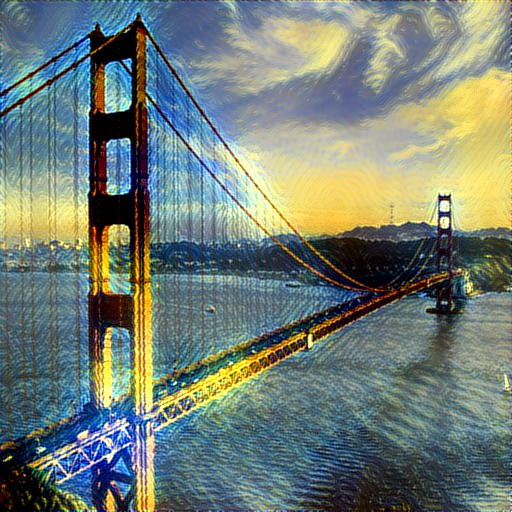

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

imge_out = Image.fromarray(image.astype('uint8'))
img_as_img = imge_out.convert("RGB")
img_as_img